### Cell 1 — Import required libraries & create data folder
This cell loads the essential Python libraries needed for the full analysis:

- **os** → for directory handling  
- **pandas, numpy** → data loading & cleaning  
- **plotly** → interactive charts  
- **Prophet** → time-series forecasting  

It also creates a folder named `data/` where the CSV file should be placed.

After running this cell, you can copy your CSV into the `data/` directory.


In [77]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
from prophet import Prophet

os.makedirs("data", exist_ok=True)
print("Ready. Put your CSV inside: data/")


Ready. Put your CSV inside: data/


### Cell 2 — Load CSV file
- Defines the file path: `data/Campaign budget analysis data export.csv`
- Checks if the file exists. If NOT, it throws an error.
- Reads the CSV while skipping top 2 metadata rows.
- Displays the initial shape and preview of the dataset.

This ensures the dataset is successfully loaded before processing.


In [45]:
file_path = "data/Campaign budget analysis data export.csv"

if not os.path.exists(file_path):
    raise FileNotFoundError(f"CSV not found at {file_path}. Place it in the data/ folder.")

df = pd.read_csv(file_path, skiprows=2)
print("CSV loaded. Shape:", df.shape)
df.head()


CSV loaded. Shape: (7370, 11)


,Campaign,Day,Campaign ID,Budget,Clicks,Impr.,Currency code,Cost,CTR,Avg. CPC,Conversions
0,SBR Pravanika | Search | 25 Nov 22,NaN,19031976471,2000.0,0,0,INR,0.00,0,0.00,0.0
1,Valmark Cityville | Search | 25 Nov 22,22-11-24,19038490303,5000.0,0,0,INR,0.00,0,0.00,0.0
2,SBR Pravanika | Search | 25 Nov 22,2022-11-25,19031976471,2000.0,3,34,INR,411.98,8.82%,137.33,0.0
3,Valmark Cityville | Search | 25 Nov 22,2022-11-25,19038490303,5000.0,5,48,INR,870.50,10.42%,174.10,0.0
4,SBR Pravanika | Search | 25 Nov 22,2022-11-26,19031976471,2000.0,11,62,INR,1147.28,17.74%,104.30,2.0


### Cell 3 — Clean & prepare the dataset
Tasks performed:
1. Renames inconsistent column names (Campaign name → Campaign, Impressions → Impr.)
2. Converts the `Day` column into a valid datetime.
3. Removes rows where the date is missing.
4. Cleans numeric columns by removing:
   - Commas (,)
   - Percentage signs (%)
5. Converts cleaned strings into numeric values.
6. Saves a backup copy of the cleaned dataset (`original_df`).

This prepares the data for modeling, plotting, and forecasting.


In [46]:
df = df.rename(columns={
    "Campaign name": "Campaign",
    "Impressions": "Impr.",
})

# Parse dates
df["Day"] = pd.to_datetime(df["Day"], errors="coerce")

df = df.dropna(subset=["Day"]).sort_values("Day")

# Clean numeric fields
numeric_cols = ["Budget", "Clicks", "Impr.", "Cost", "CTR", "Avg. CPC", "Conversions"]
for col in numeric_cols:
    if col in df.columns:
        df[col] = (
            df[col].astype(str)
            .str.replace(",", "", regex=False)
            .str.replace("%", "", regex=False)
        )
        df[col] = pd.to_numeric(df[col], errors="coerce")

original_df = df.copy()

print("\nRows AFTER cleaning:", len(df))
print("Data cleaned and original_df saved.")
df.head()




Rows AFTER cleaning: 7369
Data cleaned and original_df saved.


C:\Users\CEPL.DESKTOP-302PV1H\AppData\Local\Temp\ipykernel_24860\1891681839.py:7: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,Campaign,Day,Campaign ID,Budget,Clicks,Impr.,Currency code,Cost,CTR,Avg. CPC,Conversions
2,SBR Pravanika | Search | 25 Nov 22,2022-11-25,19031976471,2000.0,3,34,INR,411.98,8.82,137.33,0.0
3,Valmark Cityville | Search | 25 Nov 22,2022-11-25,19038490303,5000.0,5,48,INR,870.50,10.42,174.10,0.0
4,SBR Pravanika | Search | 25 Nov 22,2022-11-26,19031976471,2000.0,11,62,INR,1147.28,17.74,104.30,2.0
5,Valmark Cityville | Search | 25 Nov 22,2022-11-26,19038490303,5000.0,5,65,INR,738.82,7.69,147.76,0.0
6,SBR Pravanika | Search | 25 Nov 22,2022-11-27,19031976471,2000.0,10,56,INR,1469.71,17.86,146.97,12.0


### Cell 4 — Plot scatter charts (Before Filtering)
Creates scatter plots for multiple performance metrics vs cost:
- Clicks  
- Impressions  
- Conversions  
- CTR  
- Avg. CPC  

Colored by campaign.

Purpose:  
To visually observe raw relationships in the original unfiltered dataset.


In [47]:
print("📊 Scatter Plots BEFORE Filtering")

metrics_to_plot = ["Clicks", "Impr.", "Conversions", "CTR", "Avg. CPC"]

for metric in metrics_to_plot:
    if metric in original_df:
        fig = px.scatter(
            original_df,
            x="Cost",
            y=metric,
            color="Campaign",
            title=f"{metric} vs Cost (Before Filtering)",
            opacity=0.8
        )
        fig.update_layout(showlegend=False)
        fig.show()


📊 Scatter Plots BEFORE Filtering


### Cell 5 — Apply filtering rules
Filtering applied:
1. Remove the first **10 days** of each campaign
   (because campaigns usually need warm-up).
2. Remove records with:
   - Zero spend (`Cost == 0`)
   - Zero impressions (`Impr. == 0`)

This removes low-quality or invalid data and prepares a cleaner dataset.


In [ ]:
# Remove first 10 days of each campaign
df["Start_Day"] = df.groupby("Campaign")["Day"].transform("min")
df = df[df["Day"] >= df["Start_Day"] + pd.Timedelta(days=9)]
df = df.drop(columns=["Start_Day"])

df = df[df["Cost"] > 0]
df = df[df["Impr."] > 0]

print("Zero-Spend and Zero-Click filters applied — cleaned data ready.")
print("Rows AFTER cleaning the data:",len(df))
df.head()


Zero-Spend and Zero-Click filters applied — cleaned data ready.
Rows AFTER cleaning the data: 6410


,Campaign,Day,Campaign ID,Budget,Clicks,Impr.,Currency code,Cost,CTR,Avg. CPC,Conversions
37,SBR Pravanika | Search | 25 Nov 22,2022-12-04,19031976471,2000.0,2,12,INR,62.89,16.67,31.45,0.0
38,Valmark Cityville | Search | 25 Nov 22,2022-12-04,19038490303,5000.0,29,419,INR,4141.15,6.92,142.80,0.0
42,Valmark Cityville | Search | 25 Nov 22,2022-12-05,19038490303,5000.0,38,520,INR,6236.05,7.31,164.11,2.0
41,SBR Pravanika | Search | 25 Nov 22,2022-12-05,19031976471,2000.0,4,37,INR,510.76,10.81,127.69,0.0
45,SBR Pravanika | Search | 25 Nov 22,2022-12-06,19031976471,2000.0,5,33,INR,941.01,15.15,188.20,2.0


### Cell 6 — Plot scatter charts (After Filtering)
Plots the same metrics as before but using the filtered data.

Purpose:
To compare before/after cleaning and see how much noise is removed.


In [49]:
print("📊 Scatter Plots AFTER Filter")

for metric in metrics_to_plot:
    if metric in df.columns:
        fig = px.scatter(
            df,
            x="Cost",
            y=metric,
            color="Campaign",
            title=f"{metric} vs Cost (After Filtering)",
            opacity=0.8
        )
        fig.update_layout(showlegend=False)
        fig.show()


📊 Scatter Plots AFTER Filter


### Cell 7 — Create forecasting function
Defines `forecast_metric()`:
- Groups data by date
- Renames columns to Prophet format: ds (date), y (value)
- Fits a Prophet forecasting model
- Creates future dates
- Returns predicted values

This function will be used to forecast Clicks, Cost, Impressions, Conversions.


In [75]:
def forecast_metric(df, metric):
    temp = df.groupby("Day")[metric].mean().reset_index()
    temp = temp.rename(columns={"Day": "ds", metric: "y"})
    
    model = Prophet()
    model.fit(temp)
    
    future = model.make_future_dataframe(periods=50)
    forecast = model.predict(future)
    return forecast, temp


### Cell 8 — Forecast performance metrics
Loops over 4 metrics:
- Clicks  
- Impressions  
- Cost  
- Conversions  

For each metric:
1. Runs Prophet forecasting
2. Extracts future prediction (beyond latest date)
3. Plots actual vs predicted values

You get 4 forecasting charts automatically.


In [76]:
for metric in ["Clicks", "Impr.", "Cost", "Conversions"]:
    if metric in df.columns:
        print(f"\n Forecasting {metric}...\n")
        forecast, actual = forecast_metric(df, metric)

        latest_date = actual["ds"].max()    
        future_forecast = forecast[forecast["ds"] > latest_date]

        fig = px.line()
        fig.add_scatter(x=actual["ds"], y=actual["y"], mode="lines", name="Actual")
        fig.add_scatter(x=future_forecast["ds"], y=future_forecast["yhat"], mode="lines", name="Predicted (Future)")
        fig.update_layout(title=f"{metric} Forecast (Next 30 Days)")
        fig.show()


12:12:00 - cmdstanpy - INFO - Chain [1] start processing



 Forecasting Clicks...



12:12:00 - cmdstanpy - INFO - Chain [1] done processing


12:12:01 - cmdstanpy - INFO - Chain [1] start processing



 Forecasting Impr....



12:12:01 - cmdstanpy - INFO - Chain [1] done processing



 Forecasting Cost...



12:12:01 - cmdstanpy - INFO - Chain [1] start processing
12:12:02 - cmdstanpy - INFO - Chain [1] done processing


12:12:02 - cmdstanpy - INFO - Chain [1] start processing



 Forecasting Conversions...



12:12:02 - cmdstanpy - INFO - Chain [1] done processing


### Cell 9 — Prepare time series data for regression
Defines helper functions:
- `prepare_series()`  
  Converts metric column → y, and date → ds.
- `show_series_report()`  
  Prints the first few rows for inspection.

Used for regression/outlier detection steps.


In [67]:
def prepare_series(df, metric):
    temp = df.copy()
    if "Day" in temp.columns:
        temp = temp.rename(columns={"Day": "ds"})

    temp = temp.rename(columns={metric: "y"})
    temp = temp.reset_index(drop=True)

    return temp


def show_series_report(df, metric):

    temp = prepare_series(df, metric)
    display(temp.head())
    return temp

series_output = show_series_report(df, "Clicks")


,Campaign,ds,Campaign ID,Budget,y,Impr.,Currency code,Cost,CTR,Avg. CPC,Conversions,segment
0,SBR Pravanika | Search | 25 Nov 22,2022-12-04,19031976471,2000.0,2,12,INR,62.89,16.67,31.45,0.0,1
1,Valmark Cityville | Search | 25 Nov 22,2022-12-04,19038490303,5000.0,29,419,INR,4141.15,6.92,142.80,0.0,1
2,Valmark Cityville | Search | 25 Nov 22,2022-12-05,19038490303,5000.0,38,520,INR,6236.05,7.31,164.11,2.0,1
3,SBR Pravanika | Search | 25 Nov 22,2022-12-05,19031976471,2000.0,4,37,INR,510.76,10.81,127.69,0.0,1
4,SBR Pravanika | Search | 25 Nov 22,2022-12-06,19031976471,2000.0,5,33,INR,941.01,15.15,188.20,2.0,1


### Cell 10 — Plot removed outliers
Creates a matplotlib scatter plot:
- Green points → data kept after removing outliers
- Red points → outliers removed  

Helps visually understand what data points are dropped.


In [68]:
import matplotlib.pyplot as plt

def plot_outlier_dots(before_df, after_df):
    plt.figure(figsize=(10,6))

    plt.scatter(after_df["Cost"], after_df["y"],
                color="green", alpha=0.7, s=40, label="After Outlier Removal (Green)")

    removed_df = before_df[~before_df.index.isin(after_df.index)]
    plt.scatter(removed_df["Cost"], removed_df["y"],
                color="red", alpha=0.7, s=40, label="Removed Outliers (Red)")

    plt.title("Outlier Detection: Green = Clean Data, Red = Removed Outliers")
    plt.xlabel("Cost")
    plt.ylabel("Metric (y)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


### Cell 11 — Remove outliers using Isolation Forest
- Uses machine learning (IsolationForest) to detect unusual data points.
- Removes a small percentage (default 2%) of outliers.
- Prevents dropping too much data (retains minimum 50% dataset).
- Prints a removal report.
- Plots before vs after outlier removal.

This step ensures cleaner data for modeling.


OUTLIER REMOVAL — BEFORE vs AFTER REPORT

                    Stage  Row Count  Rows Removed  Percent Removed
0  Before Outlier Removal       6410             0             0.00
1   After Outlier Removal       6281           129             2.01

 Preview AFTER outlier removal:



,Campaign,ds,Campaign ID,Budget,y,Impr.,Currency code,Cost,CTR,Avg. CPC,Conversions,segment
0,SBR Pravanika | Search | 25 Nov 22,2022-12-04,19031976471,2000.0,2,12,INR,62.89,16.67,31.45,0.0,1
1,Valmark Cityville | Search | 25 Nov 22,2022-12-04,19038490303,5000.0,29,419,INR,4141.15,6.92,142.80,0.0,1
2,Valmark Cityville | Search | 25 Nov 22,2022-12-05,19038490303,5000.0,38,520,INR,6236.05,7.31,164.11,2.0,1
3,SBR Pravanika | Search | 25 Nov 22,2022-12-05,19031976471,2000.0,4,37,INR,510.76,10.81,127.69,0.0,1
4,SBR Pravanika | Search | 25 Nov 22,2022-12-06,19031976471,2000.0,5,33,INR,941.01,15.15,188.20,2.0,1


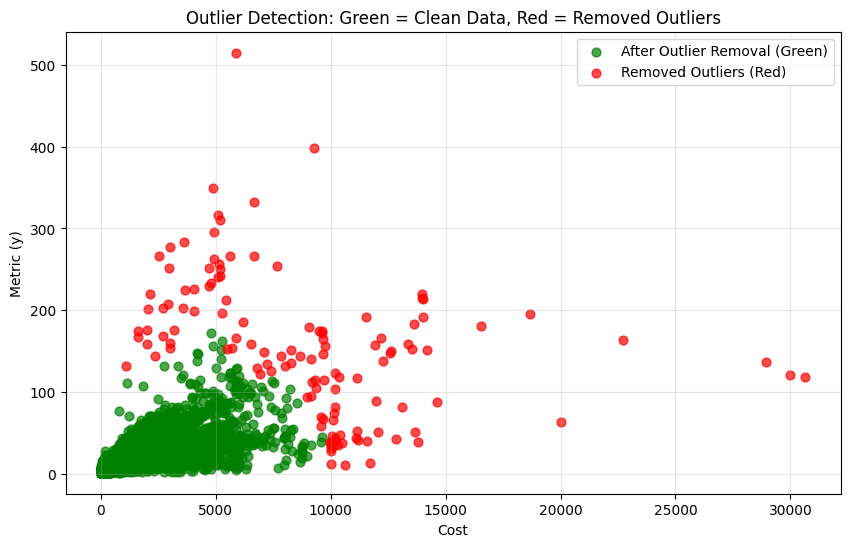

In [69]:
from sklearn.ensemble import IsolationForest

def remove_outliers(temp, contamination=0.02):
    if len(temp) < 10:
        return temp

    iso = IsolationForest(contamination=contamination, random_state=42)
    mask = iso.fit_predict(temp[["Cost", "y"]]) == 1
    filtered = temp[mask]

    return filtered if len(filtered) >= len(temp) * 0.5 else temp



def show_outlier_report(temp):
    print("OUTLIER REMOVAL — BEFORE vs AFTER REPORT\n")

    before_rows = len(temp)

    filtered = remove_outliers(temp)
    after_rows = len(filtered)

    removed = before_rows - after_rows
    percent_removed = (removed / before_rows) * 100 if before_rows > 0 else 0

    report_df = pd.DataFrame({
        "Stage": ["Before Outlier Removal", "After Outlier Removal"],
        "Row Count": [before_rows, after_rows],
        "Rows Removed": [0, removed],
        "Percent Removed": [0, round(percent_removed, 2)]
    })

    print(report_df)
    print("\n Preview AFTER outlier removal:\n")
    display(filtered.head())
    plot_outlier_dots(temp, filtered)

    return filtered


temp_after_prepare = prepare_series(df, "Clicks")
temp_after_outliers = show_outlier_report(temp_after_prepare)


### Cell 12 — Segment campaigns using clustering (KMeans)
Steps performed:
1. Aggregates performance metrics per campaign.
2. Computes efficiency KPIs:
   - CPC  
   - CPA  
   - CTR  
   - Click Efficiency  
   - Conversion Efficiency  
   - Size Index  
3. Standardizes data using StandardScaler.
4. Runs KMeans clustering to create performance-based segments.
5. Assigns each row in df a segment ID.

Also prints:
- Number of campaigns per segment
- Sample rows
- Average conversions per segment


In [70]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def improved_segment_by_campaign(df, n_segments=4):
    agg = df.groupby("Campaign").agg({
        "Cost": "sum",
        "Clicks": "sum",
        "Impr.": "sum",
        "Conversions": "sum"
    })

    agg["CPC"] = agg["Cost"] / agg["Clicks"].replace(0, np.nan)
    agg["CPA"] = agg["Cost"] / agg["Conversions"].replace(0, np.nan)
    agg["CTR"] = agg["Clicks"] / agg["Impr."].replace(0, np.nan)
    agg["Click_Eff"] = agg["Clicks"] / agg["Cost"].replace(0, np.nan)
    agg["Conv_Eff"] = agg["Conversions"] / agg["Cost"].replace(0, np.nan)
    agg["Size_Index"] = agg["Cost"] + agg["Clicks"] + agg["Impr."]

    agg = agg.replace([np.inf, -np.inf], np.nan).fillna(0)

    features = [f for f in ["CPC", "CPA", "CTR", "Click_Eff", "Conv_Eff", "Size_Index"] if f in agg.columns]
    X = agg[features].copy()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_scaled = X_scaled + np.random.normal(0, 0.01, X_scaled.shape)

    if X_scaled.shape[1] == 1:
        X_scaled = np.hstack([X_scaled, X_scaled * 0.5])

    k = min(n_segments, len(agg))
    k = max(k, 2)
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    agg["segment"] = km.fit_predict(X_scaled)

    seg_map = agg["segment"].to_dict()
    df["segment"] = df["Campaign"].map(seg_map).fillna(-1).astype(int)
    print("Segments created successfully.", df)
    return df


df_seg = improved_segment_by_campaign(df, n_segments=4)

def print_all_segments(df_seg):
    segments = sorted(df_seg["segment"].unique())

    print("\n========== SEGMENT DETAILS ==========\n")

    for seg in segments:
        seg_df = df_seg[df_seg["segment"] == seg]

        print(f"Segment {seg}")
        print("-" * 30)
        print("Total Campaigns:", seg_df["Campaign"].nunique())
        print("Total Rows in Segment:", len(seg_df))
        print("Total Conversions in Segment:", seg_df["Conversions"].sum())
        print("Average of conversions for each segment : ",seg_df["Conversions"].mean())

        print("\nCampaigns:")
        for c in seg_df["Campaign"].unique():
            print(" -", c)

        print("\nSample Rows:")
        print(seg_df.head(3))
        print("\n\n")

# RUN THE FUNCTION
print_all_segments(df_seg)
print("Rows AFTER segmenting the data:",len(df_seg))




Segments created successfully.                                                Campaign        Day  \
37                   SBR Pravanika | Search | 25 Nov 22 2022-12-04   
38               Valmark Cityville | Search | 25 Nov 22 2022-12-04   
42               Valmark Cityville | Search | 25 Nov 22 2022-12-05   
41                   SBR Pravanika | Search | 25 Nov 22 2022-12-05   
45                   SBR Pravanika | Search | 25 Nov 22 2022-12-06   
...                                                 ...        ...   
7368  Shriram Hebbal - Office Space Leasing - 30 Mar... 2025-11-10   
7364   Valmark Cityville | Search | Brand | 14 Mar 2023 2025-11-10   
7366     Greeenesto Primus - Brand Campaign - 07June 24 2025-11-10   
7367                              Cityville - 24 Jan 25 2025-11-10   
7369                Subha White Waters - Brand Campaign 2025-11-10   

      Campaign ID    Budget  Clicks  Impr. Currency code     Cost    CTR  \
37    19031976471   2000.00       2     12          

### Cell 13 — Scatter plot for segments
Plots Cost vs Clicks for each segment with different colors.

Helps you visually compare campaign behavior across clusters.


C:\Users\CEPL.DESKTOP-302PV1H\AppData\Local\Temp\ipykernel_24860\708567417.py:6: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



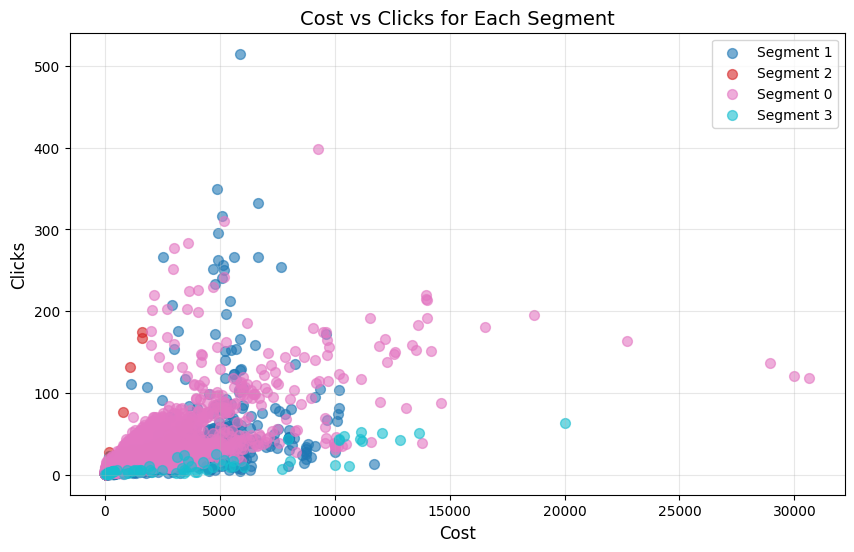

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_segments(df, x_col="Cost", y_col="Clicks"):
    segments = df["segment"].unique()
    colors = plt.cm.get_cmap('tab10', len(segments))

    plt.figure(figsize=(10,6))

    for i, seg in enumerate(segments):
        seg_df = df[df["segment"] == seg]
        plt.scatter(
            seg_df[x_col],
            seg_df[y_col],
            color=colors(i),
            label=f"Segment {seg}",
            alpha=0.6,
            s=50
        )

    plt.title(f"{x_col} vs {y_col} for Each Segment", fontsize=14)
    plt.xlabel(x_col, fontsize=12)
    plt.ylabel(y_col, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

plot_segments(df_seg, x_col="Cost", y_col="Clicks")


### Cell 14 — Fit regression models (degree 1, 2, 3)
For the selected metric:
- Fits model of degree 1 → Linear regression  
- Fits degree 2 & 3 → Polynomial regression  

For each model, calculates:
- RMSE (error)
- R² (accuracy)
- Extracts coefficients & intercepts

Also prints the equation for the **linear model**.

Finally selects the model with the **lowest RMSE** as best.


In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

def fit_models_and_select(temp, degrees=(1,2,3)):
    X = temp[['Cost']].values
    y = temp['y'].values

    results = {}

    for d in degrees:
        if d == 1:
            model = LinearRegression()
        else:
            model = make_pipeline(
                PolynomialFeatures(d, include_bias=False),
                LinearRegression()
            )

        model.fit(X, y)
        y_pred = model.predict(X)

        rmse = np.sqrt(mean_squared_error(y, y_pred))
        r2 = r2_score(y, y_pred)

        coef = None
        intercept = None
        try:
            if hasattr(model, "named_steps"):
                lin = model.named_steps.get('linearregression') or model.named_steps.get('linearregression')
                if lin is None:
                    lin = model.steps[-1][1]
            else:
                lin = model
            coef = lin.coef_
            intercept = float(lin.intercept_)
        except Exception:
            coef = None
            intercept = None

        results[d] = {
            "model": model,
            "rmse": rmse,
            "r2": r2,
            "coef": coef,
            "intercept": intercept
        }

        if d == 1 and coef is not None:
            try:
                c0 = float(np.ravel(coef)[0])
                print(f"\n=== Degree 1 (Linear Model) Equation ===\n y = {c0:.6f} * Cost + {intercept:.6f}")
            except Exception:
                pass

    best = min([k for k in results.keys() if isinstance(k, int)], key=lambda k: results[k]["rmse"])
    results["best_degree"] = best
    return results

### Cell 15 — Plot regression model fits
Plots:
- Actual data (scatter)
- Degree 1, 2, 3 fitted curves  
- Highlights the BEST model based on RMSE  

This visually compares how each regression model fits the data.


In [73]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_model_fits(temp, results, metric="y"):
    X = temp["Cost"].values.reshape(-1, 1)
    y = temp["y"].values

    # handle degenerate case where Cost is constant
    if X.min() == X.max():
        X_smooth = np.linspace(X.min() - 1, X.max() + 1, 300).reshape(-1, 1)
    else:
        X_smooth = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)

    best_degree = results["best_degree"]

    plt.figure(figsize=(12, 6))
    plt.scatter(X, y, color="black", alpha=0.4, label="Actual Data", s=45)

    colors = {1: "red", 2: "green", 3: "blue"}

    for d in [1, 2, 3]:
        if d not in results:
            continue
        model = results[d]["model"]
        try:
            y_pred_smooth = model.predict(X_smooth)
        except Exception:
            # fallback: predict on existing X if smooth fails
            y_pred_smooth = model.predict(X)

        if d == best_degree:
            plt.plot(
                X_smooth.flatten(),
                y_pred_smooth.flatten(),
                color=colors.get(d, "C0"),
                linewidth=3,
                label=f"Degree {d} (Best) — RMSE={results[d]['rmse']:.2f}",
            )
        else:
            plt.plot(
                X_smooth.flatten(),
                y_pred_smooth.flatten(),
                color=colors.get(d, "C1"),
                linewidth=1.5,
                linestyle="--",
                label=f"Degree {d} — RMSE={results[d]['rmse']:.2f}",
            )

    plt.title(f"Model Fit Comparison for {metric}")
    plt.xlabel("Cost")
    plt.ylabel(metric)
    plt.grid(True, alpha=0.4)
    plt.legend()
    plt.show()


### Cell 16 — Full model evaluation + visualization
Complete pipeline:
1. Prepare series
2. Remove outliers
3. Fit models (1,2,3)
4. Print model performance table
5. Display best model
6. Plot all fitted curves

This gives the final regression analysis for predicting performance based on cost.



MODEL FIT REPORT for Clicks


=== Degree 1 (Linear Model) Equation ===
 y = 0.008400 * Cost + 5.371494
Model performance for each degree:

   Degree       RMSE        R²
0       1  12.825713  0.495864
1       2  12.588769  0.514318
2       3  12.564716  0.516173

Best Degree Selected: 3
Total data points in graph: 6281


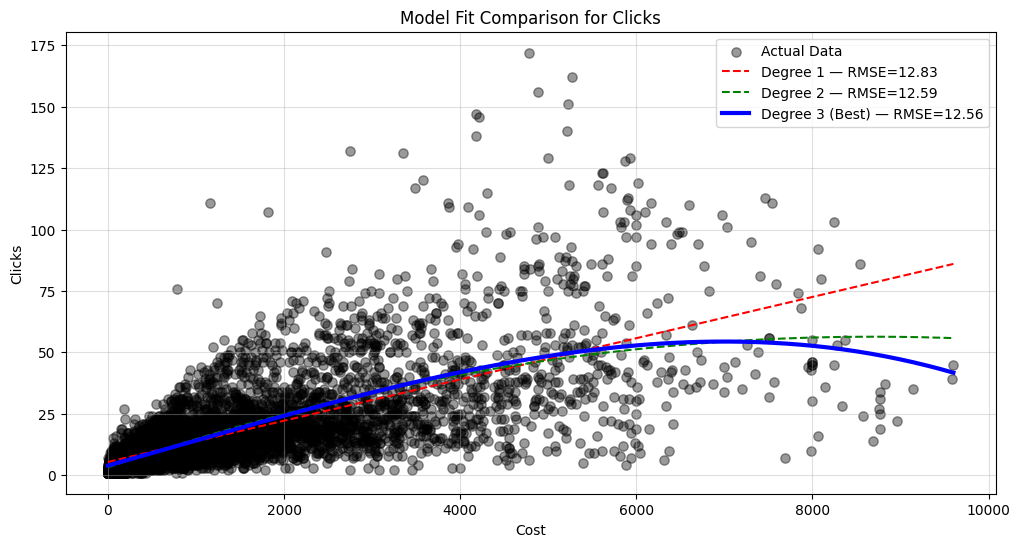

In [ ]:
def show_model_report(temp, metric):
    print(f"\nMODEL FIT REPORT for {metric}\n")

    results = fit_models_and_select(temp)

    rows = []
    for d in sorted([k for k in results.keys() if isinstance(k, int)]):
        rows.append([
            d,
            results[d]["rmse"],
            results[d]["r2"]
        ])

    report_df = pd.DataFrame(rows, columns=["Degree", "RMSE", "R²"])

    print("Model performance for each degree:\n")
    print(report_df)

    print(f"\nBest Degree Selected: {results['best_degree']}")
    return results


temp_after_prepare = prepare_series(df, "Clicks")
temp_after_outliers = remove_outliers(temp_after_prepare)

model_results = show_model_report(temp_after_outliers, "Clicks")
print("Total data points in graph:", len(temp_after_outliers))

plot_all_model_fits(temp_after_outliers, model_results, metric="Clicks")
